## Libraries

In [2]:
import numpy as np
import pandas as pd
import neptune

#Data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Building the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Training the Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Evaluate the Model
from sklearn.metrics import mean_squared_error
from math import sqrt

2024-06-04 21:37:45.569247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
#run neptune
run = neptune.init_run(
    source_files=["4_lstm_model.ipynb"],
    project="bealtaine16/co2-emission",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/bealtaine16/co2-emission/e/COEM-5


In [43]:
#log parameters
params = {
    "batch_size": 40,
    "epochs": 70,
}
run["parameters"] = params

# Data preprocessing

In [3]:
df = pd.read_csv("data/cleaned_data_first_model.csv")
df = df.reindex(columns=['year', 'country', 'population', 'gdp', 'primary_energy_consumption', 'cement_co2', 
                         'coal_co2', 'flaring_co2', 'gas_co2', 'land_use_change_co2', 'oil_co2', 'co2_including_luc'])
df['country_region'] = df['country']
df = df.set_index(['country', 'year'])
df

population           gdp  primary_energy_consumption  \
country       year                                                           
China         1990  1.153704e+09  3.385122e+12                    7938.249   
              1991  1.170626e+09  3.508948e+12                    8337.610   
              1992  1.183813e+09  3.755038e+12                    8773.708   
              1993  1.195856e+09  4.126170e+12                    9457.634   
              1994  1.207287e+09  4.438753e+12                   10048.812   
...                          ...           ...                         ...   
United States 2018  3.321400e+08  1.812469e+13                   26764.953   
              2019  3.343197e+08  1.854055e+13                   26574.742   
              2020  3.359420e+08  1.802736e+13                   24603.098   
              2021  3.369976e+08  1.909938e+13                   25945.025   
              2022  3.382899e+08  1.949317e+13                   26641.771   

                    cement_co2  coal_co2  flaring_co2   gas_co2  \
country       year                                                
China         1990      84.513  1976.684        0.000    29.301   
              1991     101.305  2049.920        0.000    30.778   
              1992     122.445  2114.715        0.000    30.239   
              1993     142.774  2228.745        0.000    35.728   
              1994     164.377  2380.586        3.737    41.568   
...                        ...       ...          ...       ...   
United States 2018      38.971  1256.631       72.066  1619.275   
              2019      40.896  1071.666       88.437  1675.471   
              2020      40.688   877.920       67.749  1656.255   
              2021      41.312  1004.531       63.294  1659.225   
              2022      41.418   934.698       63.294  1743.539   

                    land_use_change_co2   oil_co2  co2_including_luc  \
country       year                                                     
China         1990             1368.074   330.291           3852.928   
              1991             1013.113   356.027           3619.209   
              1992             1054.941   385.793           3785.728   
              1993             1087.234   428.549           4008.885   
              1994             1199.356   423.712           4303.095   
...                                 ...       ...                ...   
United States 2018              108.298  2366.168           5486.095   
              2019              112.161  2360.999           5374.306   
              2020              114.729  2047.544           4829.357   
              2021              127.596  2239.014           5159.809   
              2022              141.749  2249.519           5199.053   

                   country_region  
country       year                 
China         1990          China  
              1991          China  
              1992          China  
              1993          China  
              1994          China  
...                           ...  
United States 2018  United States  
              2019  United States  
              2020  United States  
              2021  United States  
              2022  United States  

[396 rows x 11 columns]

In [5]:
#split data to train and test model
def train_test_split_by_country_year(data, split_ratio=0.8):
    train, test = [], []

    # Iterate over each unique country in the index
    for country in data.index.get_level_values('country').unique():
        country_data = data.loc[country].copy()
        country_data['country'] = country_data['country_region']
        country_data = country_data.reset_index()
        country_data.set_index(['country_region', 'year'], inplace=True)

        # Calculate the split index
        size = int(len(country_data) * split_ratio)

        # Append the training and test sets for each country
        train.append(country_data.iloc[size:])
        test.append(country_data.iloc[size:])

    # Concatenate lists into single DataFrames
    train = pd.concat(train)
    test = pd.concat(test)

    return train, test

# Assume df is DataFrame with multi-index ('country_region', 'year')
train_df, test_df = train_test_split_by_country_year(df, split_ratio=0.8)
train_df

population           gdp  primary_energy_consumption  \
country_region year                                                           
China          2016  1.401890e+09  1.954571e+13                   35278.277   
               2017  1.410276e+09  2.089436e+13                   36649.703   
               2018  1.417069e+09  2.229428e+13                   38415.930   
               2019  1.421864e+09  2.363194e+13                   40206.684   
               2020  1.424930e+09  2.415184e+13                   41513.812   
...                           ...           ...                         ...   
United States  2018  3.321400e+08  1.812469e+13                   26764.953   
               2019  3.343197e+08  1.854055e+13                   26574.742   
               2020  3.359420e+08  1.802736e+13                   24603.098   
               2021  3.369976e+08  1.909938e+13                   25945.025   
               2022  3.382899e+08  1.949317e+13                   26641.771   

                     cement_co2  coal_co2  flaring_co2   gas_co2  \
country_region year                                                
China          2016     743.044  7071.404        3.090   421.726   
               2017     758.185  7163.318        2.969   486.359   
               2018     786.745  7316.400        3.408   575.369   
               2019     826.876  7523.170        3.839   630.171   
               2020     858.233  7679.546        5.170   676.473   
...                         ...       ...          ...       ...   
United States  2018      38.971  1256.631       72.066  1619.275   
               2019      40.896  1071.666       88.437  1675.471   
               2020      40.688   877.920       67.749  1656.255   
               2021      41.312  1004.531       63.294  1659.225   
               2022      41.418   934.698       63.294  1743.539   

                     land_use_change_co2   oil_co2  co2_including_luc  \
country_region year                                                     
China          2016              213.326  1357.838           9978.354   
               2017              461.403  1430.587          10472.555   
               2018              696.514  1500.474          11050.448   
               2019              749.990  1559.728          11471.032   
               2020              829.416  1523.052          11743.429   
...                                  ...       ...                ...   
United States  2018              108.298  2366.168           5486.095   
               2019              112.161  2360.999           5374.306   
               2020              114.729  2047.544           4829.357   
               2021              127.596  2239.014           5159.809   
               2022              141.749  2249.519           5199.053   

                           country  
country_region year                 
China          2016          China  
               2017          China  
               2018          China  
               2019          China  
               2020          China  
...                            ...  
United States  2018  United States  
               2019  United States  
               2020  United States  
               2021  United States  
               2022  United States  

[84 rows x 11 columns]

In [10]:
# Normalize the categorical features
encoder = LabelEncoder()
categorical_feature_train = pd.Series(encoder.fit_transform(train_df.pop('country')), index=train_df.index)
categorical_feature_test = pd.Series(encoder.transform(test_df.pop('country')), index=test_df.index)
print(train_df)

# Normalize the numerical features
scaler = MinMaxScaler()
numerical_features_train_scaled = scaler.fit_transform(train_df)  # Fit and transform training data
numerical_features_test_scaled = scaler.transform(test_df) # Transform test data using the fitted scaler

# Convert scaled numerical features back to DataFrame
numerical_features_train_scaled = pd.DataFrame(numerical_features_train_scaled, columns=train_df.columns, index=train_df.index)
numerical_features_test_scaled = pd.DataFrame(numerical_features_test_scaled, columns=test_df.columns, index=test_df.index)

# Concatenate the encoded categorical feature with the scaled numerical features
train_scaled_df = pd.concat([categorical_feature_train.to_frame('country'), numerical_features_train_scaled], axis=1)
test_scaled_df = pd.concat([categorical_feature_test.to_frame('country'), numerical_features_test_scaled], axis=1)

                       population           gdp  primary_energy_consumption  \
country_region year                                                           
China          2016  1.401890e+09  1.954571e+13                   35278.277   
               2017  1.410276e+09  2.089436e+13                   36649.703   
               2018  1.417069e+09  2.229428e+13                   38415.930   
               2019  1.421864e+09  2.363194e+13                   40206.684   
               2020  1.424930e+09  2.415184e+13                   41513.812   
...                           ...           ...                         ...   
United States  2018  3.321400e+08  1.812469e+13                   26764.953   
               2019  3.343197e+08  1.854055e+13                   26574.742   
               2020  3.359420e+08  1.802736e+13                   24603.098   
               2021  3.369976e+08  1.909938e+13                   25945.025   
               2022  3.382899e+08  1.949317e+13     

In [61]:
train_scaled_df

country  population       gdp  \
country_region year                                  
China          2016        0    0.982762  0.721636   
               2017        0    0.988784  0.772229   
               2018        0    0.993663  0.824746   
               2019        0    0.997106  0.874926   
               2020        0    0.999308  0.894430   
...                      ...         ...       ...   
United States  2018       11    0.214527  0.668328   
               2019       11    0.216092  0.683929   
               2020       11    0.217257  0.664677   
               2021       11    0.218015  0.704892   
               2022       11    0.218943  0.719665   

                     primary_energy_consumption  cement_co2  coal_co2  \
country_region year                                                     
China          2016                    0.793767    0.865225  0.857057   
               2017                    0.825201    0.882940  0.868198   
               2018                    0.865684    0.916357  0.886752   
               2019                    0.906730    0.963311  0.911814   
               2020                    0.936690    1.000000  0.930768   
...                                         ...         ...       ...   
United States  2018                    0.598634    0.041436  0.152267   
               2019                    0.594274    0.043688  0.129848   
               2020                    0.549082    0.043445  0.106365   
               2021                    0.579841    0.044175  0.121711   
               2022                    0.595811    0.044299  0.113247   

                     flaring_co2   gas_co2  land_use_change_co2   oil_co2  \
country_region year                                                         
China          2016     0.034940  0.223106             0.216167  0.567858   
               2017     0.033572  0.261094             0.442020  0.599036   
               2018     0.038536  0.313410             0.656068  0.628988   
               2019     0.043409  0.345620             0.704754  0.654383   
               2020     0.058460  0.372834             0.777064  0.638664   
...                          ...       ...                  ...       ...   
United States  2018     0.814885  0.926964             0.120548  1.000000   
               2019     1.000000  0.959993             0.124065  0.997785   
               2020     0.766071  0.948699             0.126403  0.863447   
               2021     0.715696  0.950445             0.138117  0.945505   
               2022     0.715696  1.000000             0.151002  0.950008   

                     co2_including_luc  
country_region year                     
China          2016           0.803818  
               2017           0.844216  
               2018           0.891456  
               2019           0.925837  
               2020           0.948104  
...                                ...  
United States  2018           0.436597  
               2019           0.427459  
               2020           0.382912  
               2021           0.409925  
               2022           0.413133  

[84 rows x 11 columns]

In [48]:
# Function to convert series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Aggregate the data
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Function to reshape data for LSTM training
def reshape_data(train, test):
    # Frame as supervised learning
    reframed_train = series_to_supervised(train, 3, 1)
    reframed_test = series_to_supervised(test, 3, 1)
    print(reframed_train)
    # Split into input and outputs
    train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
    test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
    # Reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train, x_test, train_y, test_y

In [49]:
# Using the function to obtain reshaped x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = reshape_data(train_df, test_df)

                        var1(t-3)     var2(t-3)  var3(t-3)  var4(t-3)  \
country_region year                                                     
China          2019  1.401890e+09  1.954571e+13  35278.277    743.044   
               2020  1.410276e+09  2.089436e+13  36649.703    758.185   
               2021  1.417069e+09  2.229428e+13  38415.930    786.745   
               2022  1.421864e+09  2.363194e+13  40206.684    826.876   
Germany        2016  1.424930e+09  2.415184e+13  41513.812    858.233   
...                           ...           ...        ...        ...   
United States  2018  6.750894e+07  2.615231e+12   2031.876      4.073   
               2019  3.272102e+08  1.722007e+13  25723.152     39.439   
               2020  3.297912e+08  1.760613e+13  25819.029     40.324   
               2021  3.321400e+08  1.812469e+13  26764.953     38.971   
               2022  3.343197e+08  1.854055e+13  26574.742     40.896   

                     var5(t-3)  var6(t-3)  var7(t-

In [50]:
x_train.shape

(81, 1, 39)

# Building the LSTM Model

In [51]:
# Model architecture adjusted for cuDNN
model = Sequential([
    LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

2024-06-03 20:51:49.981915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 20:51:49.983228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 20:51:49.984711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 50)             18000     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In [52]:
x_train


array([[[1.40188966e+09, 1.95457080e+13, 3.52782770e+04, ...,
         6.30171000e+02, 7.49990000e+02, 1.55972800e+03]],

       [[1.41027597e+09, 2.08943618e+13, 3.66497030e+04, ...,
         6.76473000e+02, 8.29416000e+02, 1.52305200e+03]],

       [[1.41706944e+09, 2.22942841e+13, 3.84159300e+04, ...,
         7.64102000e+02, 9.04296000e+02, 1.56437000e+03]],

       ...,

       [[3.29791232e+08, 1.76061251e+13, 2.58190290e+04, ...,
         1.65625500e+03, 1.14729000e+02, 2.04754400e+03]],

       [[3.32140032e+08, 1.81246932e+13, 2.67649530e+04, ...,
         1.65922500e+03, 1.27596000e+02, 2.23901400e+03]],

       [[3.34319680e+08, 1.85405533e+13, 2.65747420e+04, ...,
         1.74353900e+03, 1.41749000e+02, 2.24951900e+03]]])

# Training the Model

In [53]:
from neptune.integrations.tensorflow_keras import NeptuneCallback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [54]:
# Callbacks
#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    validation_split=0.2,
    verbose=1,
    callbacks=[NeptuneCallback(run=run)]
) #callbacks=[checkpoint, early_stopping])

Epoch 1/70


2024-06-03 20:51:57.726487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 20:51:57.728214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 20:51:57.729508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - ETA: 0s - loss: 10723241.0000

2024-06-03 20:52:01.650093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 20:52:01.651584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 20:52:01.652639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 5s 1s/step - loss: 10723241.0000 - val_loss: 11415841.0000
Epoch 2/70
1/2 [==============>...............] - ETA: 0s - loss: 5571373.5000

2024-06-03 20:52:02.186933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step - loss: 10723136.0000 - val_loss: 11415610.0000
Epoch 3/70
2/2 [==============================] - 0s 57ms/step - loss: 10722820.0000 - val_loss: 11415379.0000
Epoch 4/70
2/2 [==============================] - 0s 55ms/step - loss: 10722752.0000 - val_loss: 11415147.0000
Epoch 5/70
2/2 [==============================] - 0s 54ms/step - loss: 10722474.0000 - val_loss: 11414920.0000
Epoch 6/70
2/2 [==============================] - 0s 52ms/step - loss: 10722365.0000 - val_loss: 11414692.0000
Epoch 7/70
2/2 [==============================] - 0s 55ms/step - loss: 10722060.0000 - val_loss: 11414460.0000
Epoch 8/70
2/2 [==============================] - 0s 58ms/step - loss: 10721896.0000 - val_loss: 11414221.0000
Epoch 9/70
2/2 [==============================] - 0s 57ms/step - loss: 10721696.0000 - val_loss: 11413880.0000
Epoch 10/70
2/2 [==============================] - 0s 58ms/step - loss: 10721548.0000 - val_loss: 11413628.0000
Epoch 11/70

# Evaluate the Model

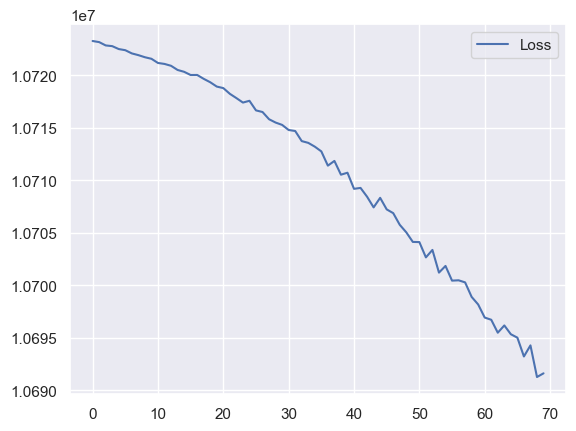

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [56]:
# make a prediction
y_test_pre=model.predict(x_test)
# check length
y_test_pre.shape,y_test.shape

2024-06-03 20:52:13.406961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 20:52:13.410106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 20:52:13.412772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 26ms/step


((81, 1), (81,))

In [19]:
x_test

array([[[1.40188966e+09, 1.95457080e+13, 3.52782770e+04, ...,
         6.30171000e+02, 7.49990000e+02, 1.55972800e+03]],

       [[1.41027597e+09, 2.08943618e+13, 3.66497030e+04, ...,
         6.76473000e+02, 8.29416000e+02, 1.52305200e+03]],

       [[1.41706944e+09, 2.22942841e+13, 3.84159300e+04, ...,
         7.64102000e+02, 9.04296000e+02, 1.56437000e+03]],

       ...,

       [[3.29791232e+08, 1.76061251e+13, 2.58190290e+04, ...,
         1.65625500e+03, 1.14729000e+02, 2.04754400e+03]],

       [[3.32140032e+08, 1.81246932e+13, 2.67649530e+04, ...,
         1.65922500e+03, 1.27596000e+02, 2.23901400e+03]],

       [[3.34319680e+08, 1.85405533e+13, 2.65747420e+04, ...,
         1.74353900e+03, 1.41749000e+02, 2.24951900e+03]]])

In [22]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().year.iloc[1:-1]
pa['Country']=X_test.reset_index().country_region.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa = pa[pa['Country'] == 'Germany']
pa

NameError: name 'X_test' is not defined

In [ ]:
pa.groupby('Date')['Prediction'].sum()

In [ ]:
plt.figure(figsize=(15,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('CO2',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - CO2',fontsize=20)
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [ ]:
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

In [57]:
# Save and log the model
model.save("model.h5")
run["model"].upload("model.h5")

# Stop the Neptune run
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/bealtaine16/co2-emission/e/COEM-5/metadata
